In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import eli5
from eli5.sklearn import PermutationImportance
import pandas as pd
import shap 
from sklearn import preprocessing 


# Read the data
X_full = pd.read_csv("cleandata2.csv")

# Label encoding team IDs
le = preprocessing.LabelEncoder()
le2 = preprocessing.LabelEncoder()
X_full["HOME_TEAM_ID_encoded"] = le.fit_transform(X_full["HOME_TEAM_ID"])
X_full["VISITOR_TEAM_ID_encoded"] = le.transform(X_full["VISITOR_TEAM_ID"])
X_full["SEASON_encoded"] = le2.fit_transform(X_full["SEASON"])
# Drop old columns
X_full = X_full.drop(columns =[
    "HOME_TEAM_ID","VISITOR_TEAM_ID",
    "GAME_DATE_EST", "PTS_home",
    "PTS_away","SEASON"], axis=1)
X_full["diff"] = X_full.apply(lambda row: row.avgpointtotal_home - row.avgpointtotal_away, axis=1)
cols = X_full.columns 
print(cols)

Index(['point_total', 'point_average_last10', 'point_againts_average_last10',
       'away_point_average_last10', 'away_point_againts_average_last10', 'cgp',
       'wins', 'losses', 'winpercent', 'cgp_away', 'wins_away', 'losses_away',
       'winpercen_away', 'hometeam-homewins', 'hometeam-awaywins',
       'awayteam-homewins', 'awayteam-awaywins', 'avgpointtotal_home',
       'avgpointtotal_away', 'meanpointtotal', 'HOME_TEAM_ID_encoded',
       'VISITOR_TEAM_ID_encoded', 'SEASON_encoded', 'diff'],
      dtype='object')


In [2]:
cols = cols.drop("HOME_TEAM_ID_encoded")
cols = cols.drop("VISITOR_TEAM_ID_encoded")
cols = cols.drop("SEASON_encoded")
cols = cols.drop("point_total")

In [250]:
print (X_full)

       point_total  point_average_last10  point_againts_average_last10  \
0            178.0                 98.55                        108.05   
1            202.0                116.10                        123.15   
2            266.0                116.65                        109.30   
3            251.0                112.35                        109.50   
4            206.0                112.65                        112.55   
...            ...                   ...                           ...   
11910        180.0                 96.35                         95.70   
11911        166.0                 94.00                         91.00   
11912        193.0                107.30                        114.65   
11913        193.0                100.60                         99.20   
11914        184.0                 97.25                         95.50   

       away_point_average_last10  away_point_againts_average_last10  cgp  \
0                         122.20   

In [3]:
for i in cols:
    print (i)
    X_full[i+"_scale"] = preprocessing.scale(X_full[i])
    
#X_full.drop(i)
print (X_full)

point_average_last10
point_againts_average_last10
away_point_average_last10
away_point_againts_average_last10
cgp
wins
losses
winpercent
cgp_away
wins_away
losses_away
winpercen_away
hometeam-homewins
hometeam-awaywins
awayteam-homewins
awayteam-awaywins
avgpointtotal_home
avgpointtotal_away
meanpointtotal
diff
       point_total  point_average_last10  point_againts_average_last10  \
0            178.0                 98.55                        108.05   
1            202.0                116.10                        123.15   
2            266.0                116.65                        109.30   
3            251.0                112.35                        109.50   
4            206.0                112.65                        112.55   
...            ...                   ...                           ...   
11910        180.0                 96.35                         95.70   
11911        166.0                 94.00                         91.00   
11912        193.0   

In [4]:
X_full= X_full.drop(cols,axis=1)
    
print (X_full)

       point_total  HOME_TEAM_ID_encoded  VISITOR_TEAM_ID_encoded  \
0            178.0                    29                       12   
1            202.0                    13                        5   
2            266.0                     9                       18   
3            251.0                     6                       24   
4            206.0                    21                       28   
...            ...                   ...                      ...   
11910        180.0                     0                        3   
11911        166.0                     4                       27   
11912        193.0                    10                        6   
11913        193.0                    24                       21   
11914        184.0                    11                        3   

       SEASON_encoded  point_average_last10_scale  \
0                   8                   -0.377465   
1                   8                    2.645345   
2           

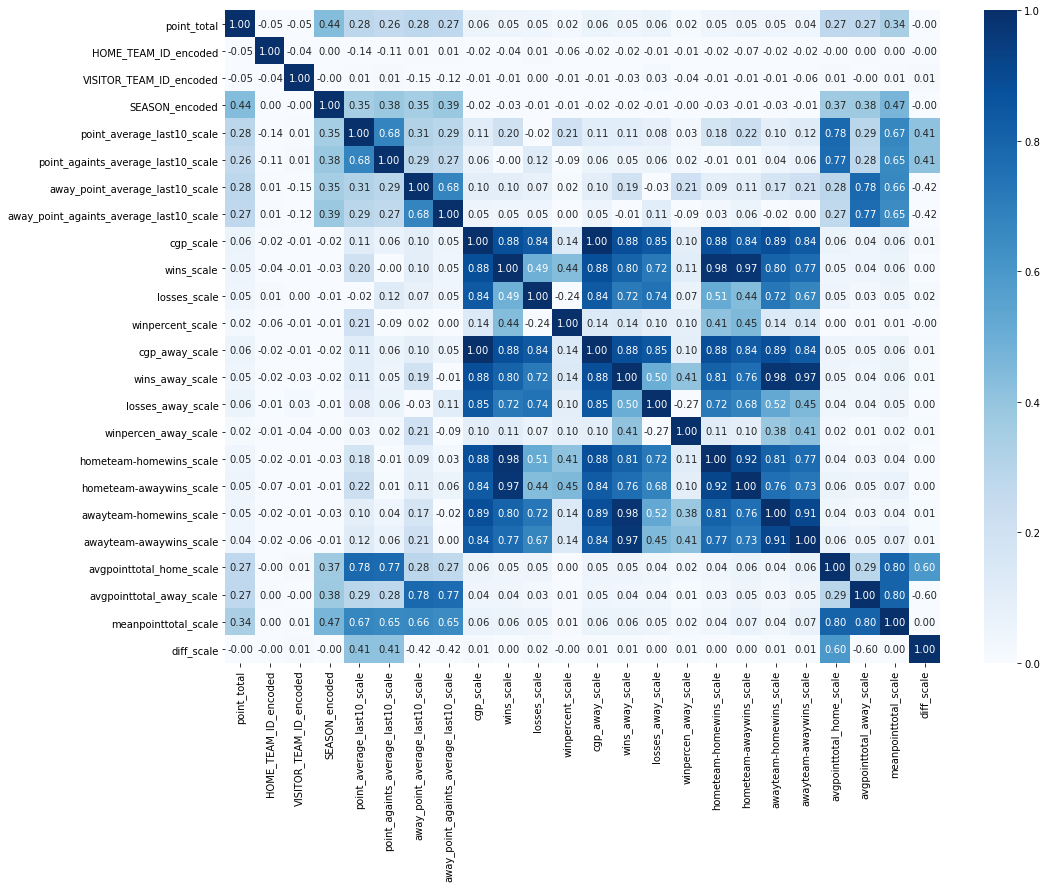

In [254]:
# Alot of these varriable are not needed do to the correlation
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))
sns.heatmap(X_full.corr(),
            cmap="Blues",annot=True, fmt='.2f', vmin=0);

In [5]:
# Columns that have high correlation 
cols_drop = ['cgp_scale','losses_scale','cgp_away_scale',
             'losses_away_scale',
            'avgpointtotal_home_scale',
            "avgpointtotal_away_scale","point_total"]

X = X_full.drop(cols_drop, axis=1)
y = X_full["point_total"]

In [6]:
corr_list = X[X.columns[1:]].apply(
    lambda x: x.corr(y))
cols = []
for col in corr_list.index:
    if (corr_list[col]>0.1 or corr_list[col] <-0.1):
        cols.append(col)
print(cols)

['SEASON_encoded', 'point_average_last10_scale', 'point_againts_average_last10_scale', 'away_point_average_last10_scale', 'away_point_againts_average_last10_scale', 'meanpointtotal_scale']


In [7]:
#dropping everything but cols
#adding the encoded team ids to the list,
#even though they are not correlated 
#cols.append("HOME_TEAM_ID_encoded")
#cols.append("VISITOR_TEAM_ID_encoded")
#cols.clear()
#cols.append("meanpointtotal")
#cols.append("SEASON_encoded")
#X = X[cols]
# tried dropping some of the correlated columns
#X = X.drop(columns=["avgpointtotal_home","avgpointtotal_away",
#                   "away_point_againts_average_last10",
#                     "point_againts_average_last10",])
#splitting the data 80-20
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      train_size=0.8, 
                                                      test_size=0.2, 
                                                      random_state=0)

In [8]:
print(X.columns)
print(X.shape)

Index(['HOME_TEAM_ID_encoded', 'VISITOR_TEAM_ID_encoded', 'SEASON_encoded',
       'point_average_last10_scale', 'point_againts_average_last10_scale',
       'away_point_average_last10_scale',
       'away_point_againts_average_last10_scale', 'wins_scale',
       'winpercent_scale', 'wins_away_scale', 'winpercen_away_scale',
       'hometeam-homewins_scale', 'hometeam-awaywins_scale',
       'awayteam-homewins_scale', 'awayteam-awaywins_scale',
       'meanpointtotal_scale', 'diff_scale'],
      dtype='object')
(11915, 17)


In [206]:
import matplotlib.pyplot as plt
import seaborn as sns
#colstar = cols
#colstar.append("point_total")
x_y = X
x_y["point_total"]= y
print(x_y.columns)

Index(['HOME_TEAM_ID_encoded', 'VISITOR_TEAM_ID_encoded', 'SEASON_encoded',
       'point_average_last10_scale', 'point_againts_average_last10_scale',
       'away_point_average_last10_scale',
       'away_point_againts_average_last10_scale', 'cgp_scale', 'wins_scale',
       'losses_scale', 'winpercent_scale', 'cgp_away_scale', 'wins_away_scale',
       'losses_away_scale', 'winpercen_away_scale', 'hometeam-homewins_scale',
       'hometeam-awaywins_scale', 'awayteam-homewins_scale',
       'awayteam-awaywins_scale', 'avgpointtotal_home_scale',
       'avgpointtotal_away_scale', 'meanpointtotal_scale', 'point_total'],
      dtype='object')


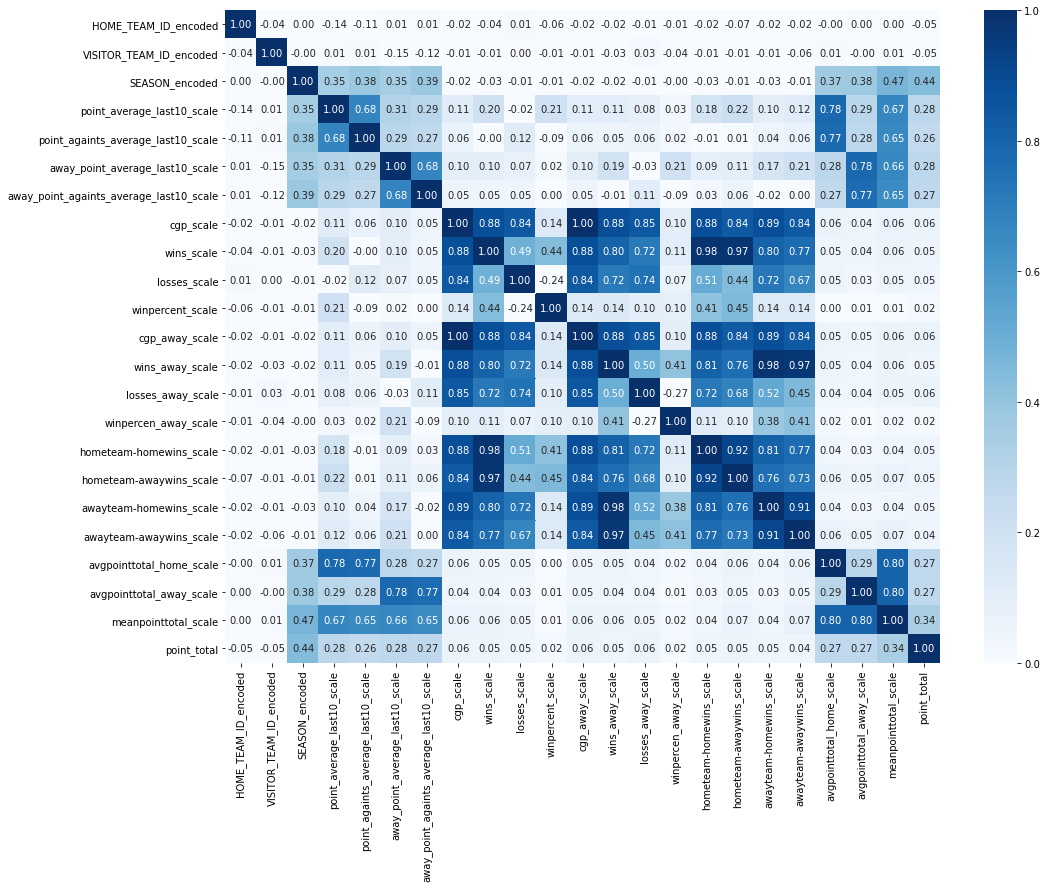

In [207]:
plt.figure(figsize=(16, 12))
sns.heatmap(x_y.corr(),
           cmap="Blues",annot=True, fmt='.2f', vmin=0);

In [ ]:
import numpy as np 
def meanerror(pred,valid):
   reutrn np.mean(pred - valid) 

In [9]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error

EN = RidgeCV().fit(X_train,y_train)

pred_EN = EN.predict(X_valid)
mae_EN = mean_absolute_error(pred_EN, y_valid)
print ("mae",mae_EN)

mae 15.391680249654256


In [17]:
X_train.columns

Index(['HOME_TEAM_ID_encoded', 'VISITOR_TEAM_ID_encoded', 'SEASON_encoded',
       'point_average_last10_scale', 'point_againts_average_last10_scale',
       'away_point_average_last10_scale',
       'away_point_againts_average_last10_scale', 'wins_scale',
       'winpercent_scale', 'wins_away_scale', 'winpercen_away_scale',
       'hometeam-homewins_scale', 'hometeam-awaywins_scale',
       'awayteam-homewins_scale', 'awayteam-awaywins_scale',
       'meanpointtotal_scale', 'diff_scale'],
      dtype='object')

In [10]:
#lin reg 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

lin = LinearRegression(normalize=True, ).fit(X_train,y_train)

pred_lin = lin.predict(X_valid)
penis = []
for i in range(469):
    penis.append(221)

mae_lin = mean_absolute_error(pred_lin, y_valid)
score = lin.score(X_valid, y_valid, sample_weight=None)
crossval = cross_val_score(lin, X_train, y_train,
                           cv=5, scoring="neg_mean_absolute_error")
print("score function",score)
print("number of test columns",len(y_valid))
print("mae", mae_lin)
print("corssval",crossval)
print("crossvalmean",crossval.mean())
print(X_train.columns)
print(y_valid.min())

score function 0.2300275026969919
number of test columns 2383
mae 15.391587724193162
corssval [-15.14415072 -15.28371614 -15.14249998 -15.20263668 -15.18088788]
crossvalmean -15.19077828101966
Index(['HOME_TEAM_ID_encoded', 'VISITOR_TEAM_ID_encoded', 'SEASON_encoded',
       'point_average_last10_scale', 'point_againts_average_last10_scale',
       'away_point_average_last10_scale',
       'away_point_againts_average_last10_scale', 'wins_scale',
       'winpercent_scale', 'wins_away_scale', 'winpercen_away_scale',
       'hometeam-homewins_scale', 'hometeam-awaywins_scale',
       'awayteam-homewins_scale', 'awayteam-awaywins_scale',
       'meanpointtotal_scale', 'diff_scale'],
      dtype='object')
139.0


In [ ]:
print(y.shape)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

bg = RandomForestRegressor(criterion="mae").fit(X_train,y_train)

In [16]:

pred_bag = bg.predict(X_valid)
mae_bag = mean_absolute_error(pred_bag, y_valid)
print('mae', mae_bag)
crossval = cross_val_score(bg, X_train, y_train,
                           cv=5, scoring="neg_mean_absolute_error")
print (crossval)
c = sum(crossval)/5
print ("crossvalmean", c)

mae 14.752099279619527
[-14.79083407 -14.80248003 -15.00677368 -14.88321484 -14.85698473]
crossvalmean -14.868057470572097


In [237]:
from sklearn.neural_network import MLPRegressor

regr = MLPRegressor(random_state=1, max_iter=1000).fit(X_train, y_train)
pred_mlp = regr.predict(X_valid)
mae_regr = mean_absolute_error(pred_mlp, y_valid)
print("mae",mae_regr)
crossval = cross_val_score(regr, X_train, y_train,
                           cv=5, scoring="neg_mean_absolute_error")
print (crossval)
print (crossval.mean())

mae 15.247579994962217
[-14.97750978 -15.09251646 -15.04471354 -15.22786912 -14.96099302]
-15.06072038576178


In [238]:
import xgboost as xgb

xg = xgb.XGBRegressor(booster="gblinear").fit(X_train,y_train)
pred_xg = xg.predict(X_valid)
xg_regr = mean_absolute_error(pred_xg, y_valid)
#score = lin.score(X_valid, y_valid, sample_weight=None)
crossval_xg = cross_val_score(xg, X_train, y_train,
                           cv=5)
#print("score function",score)
print("number of test columns",len(y_valid))
print("corssval",crossval_xg)
print("crossvalmean",crossval_xg.mean())
print("mae",xg_regr)
print("done")


number of test columns 2383
corssval [0.24142581 0.23895909 0.20411069 0.20826208 0.21878944]
crossvalmean 0.22230942091003608
mae 15.429776062447136
done


In [226]:
ls = []
for i in range(len(pred_bag)):
    ls.append(pred_bag[i] - y_valid.iloc[i])
    #print(x)
print (sum(ls))
    
    


-590.7327175324673


In [227]:
# 80-20 split would only leave 10% of the training data being used from the 2019 season
# Since teams change a lot during the season, we would like to have more data from this season when training
# However we do not was to reduce the power of our validation process
# We will be using a 85-15 train_test_split
from sklearn.ensemble import RandomForestRegressor
# Break off validation set from training data 

# Base model
first_model = RandomForestRegressor().fit(X_train,y_train)
perm = PermutationImportance(first_model, random_state=1).fit(X_valid, y_valid)
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())
eli5.show_weights(perm, feature_names = X_valid.columns.tolist())



Weight,Feature
0.3171 ± 0.0103,SEASON_encoded
0.0528 ± 0.0073,meanpointtotal_scale
0.0179 ± 0.0062,point_average_last10_scale
0.0125 ± 0.0040,away_point_average_last10_scale
0.0123 ± 0.0018,VISITOR_TEAM_ID_encoded
0.0116 ± 0.0073,point_againts_average_last10_scale
0.0077 ± 0.0045,away_point_againts_average_last10_scale
0.0049 ± 0.0038,awayteam-homewins_scale
0.0048 ± 0.0032,HOME_TEAM_ID_encoded
0.0040 ± 0.0030,avgpointtotal_home_scale


In [ ]:
#Linear regression 
